In [1]:
import numpy as np
import pandas as pd
import os
import argparse
import time
import math
import random
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import torch
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import gzip
import pickle
import numpy as np
from torch.autograd import Variable
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import torchsnooper

from tqdm import tqdm

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
'''
These 2 parameters define the range of waveform we'd like to analyze
'''
LSPAN = 200 # number of time samples prior to t0
HSPAN = 400 # number of time samples after t0

In [3]:
#This function gets the false positive rate, true positive rate, cutting threshold and area under curve using the given signal and background array
# def get_roc(sig,bkg):
#     testY = np.array([1]*len(sig) + [0]*len(bkg))
#     predY = np.array(sig+bkg)
#     auc = roc_auc_score(testY, predY)
#     fpr, tpr, thr = roc_curve(testY, predY)
#     return fpr,tpr,thr,auc

In [4]:
def loadwf(filename):
    dset=np.load(filename)
    return (dset["train"],dset["train_label"]),(dset["test"],dset["test_label"])

#extract the waveforms from the simulation file:shift range and labeling provided (1 for pileup), and save waveforms to a new file
def wf_extract(sft, label):
    filename = "pileup-sims-0-" + str(sft) + ".npz"
    (x_train,y_train),(x_test,y_test)=loadwf(filename)
    #normalizing the waveform incase if they were not normalized
    train_x = np.array([x_train[i]/np.max(x_train[i]) for i in range(len(x_train))])
    test_x = np.array([x_test[i]/np.max(x_test[i]) for i in range(len(x_test))])

    #labeling of the waveform
    train_y = y_train
    test_y = y_test
    if label ==1:# finding the pileup waveform
        nwftrain =  np.argwhere(train_y == 1)
        nwftest = np.argwhere(test_y == 1)
    
    elif label ==0: # finding the NOpileup waveform
        nwftrain =  np.argwhere(train_y == 0)
        nwftest = np.argwhere(test_y == 0)
        
    else:
        print("please provide the labeling number 1 or 0: 1 for pileup waveform, and 0 for NoPileup waveform")
        
    l = np.array([nwftrain[i][0] for i in range(len(nwftrain))]) 
    nwftrain_x = np.array([train_x[l[i]] for i in range(len(l))])

    l1 = np.array([nwftest[i][0] for i in range(len(nwftest))])
    nwftest_x = np.array([test_x[l1[i]] for i in range(len(l1))])
    nwf_x = np.concatenate((nwftest_x,nwftrain_x),axis = 0)
    count = len(nwf_x)
    event_dict={}
    if label == 1:
        file_name = "PILEUP_"+str(sft)+".pickle"
        with open(file_name, 'wb') as handle:
            for i in range(count):  
                nwf=nwf_x[i]
                event_dict = {"wf":nwf}
                pickle.dump(event_dict,handle, protocol=pickle.HIGHEST_PROTOCOL)
    elif label ==0:
        file_name="NOPILEUP_"+str(sft)+".pickle"
        with open(file_name, 'wb') as handle:
            for i in range(count):  
                nwf=nwf_x[i]
                event_dict = {"wf":nwf}
                pickle.dump(event_dict,handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [5]:
class DetectorDataset(Dataset):
    
    def __init__(self, sft,dsize=-1):
        self.sft=sft
        dep = "NOPILEUP_"+str(sft)+".pickle"
        sep = "PILEUP_"+str(sft)+".pickle"
        DEP_dict = self.event_loader(dep)
        SEP_dict = self.event_loader(sep)

        if dsize == -1:
            dsize = min(len(DEP_dict), len(SEP_dict))
        
        #Shuffle dataset and select #dsize event from DEP and SEP
        np.random.shuffle(DEP_dict)
        np.random.shuffle(SEP_dict)
        DEP_dict = DEP_dict[:dsize]
        SEP_dict = SEP_dict[:dsize]
        self.event_dict = DEP_dict + SEP_dict
        self.label = ([1]*len(DEP_dict)) + ([0] * len(SEP_dict))
#         print(len(self.event_dict))
#         print(len(self.label))
        
        self.size = len(self.event_dict)
#         print(self.size)
        
    def __len__(self):
        return self.size
    
    def build_scaler(self):
        '''
        '''
        wf_array = []
        for i in range(self.size):
            wf_array.append(self.get_wf(i).reshape(1,-1))
        wf_array = np.concatenate(wf_array,axis=0)
        scaler = StandardScaler()
        scaler.fit(wf_array)
        return scaler
    
    def get_scaler(self):
        return self.scaler
    
    def set_scaler(self,scaler):
        self.scaler = scaler
    
    def get_wf(self,idx):
        event = self.event_dict[idx]
        wf = np.array(event["wf"]).flatten()
        midindex = 200

        #baseline subtraction
        wf -= np.average(wf[:(midindex-50)])
        
        #Extract waveform from its t0
        wfbegin = midindex - LSPAN
        wfend = midindex + HSPAN
        
        wf = wf[wfbegin:wfend]
        wf = (wf - np.min(wf)) / (np.max(wf) - np.min(wf))#rescale wf to between 0 and 1      
        return wf

    def __getitem__(self, idx):
        event = self.event_dict[idx]
        wf = np.array(event["wf"]).flatten()
        midindex = 200
        wf = self.get_wf(idx)
        wf = torch.from_numpy(wf).float() 
        
        return wf, self.label[idx]
    
    def return_label(self):
        return self.trainY

#     def return_detector_array(self):
#         return self.detector_name
    
    #Load event from .pickle file
    def event_loader(self, address):
        wf_list = []
        with (open(address, "rb")) as openfile:
            while True:
#                 if len(wf_list) > 2000:
#                     break
                try:
                   wf_list.append(pickle.load(openfile, encoding='latin1'))
                except EOFError:
                    break
        return wf_list
    
    def get_field_from_dict(self, input_dict, fieldname):
        field_list = []
        for event in input_dict:
            field_list.append(event[fieldname])
        return field_list
    
    def plot_offset_correction(self):
        plt.subplot(211)
        
        plt.subplot(212)
# next(iter(DetectorDataset()))

In [6]:
#Load dataset
def load_data(batch_size,sft):
    dataset = DetectorDataset(sft)
    validation_split = .3 #Split data set into training & testing with 7:3 ratio
    shuffle_dataset = True
    random_seed= 42222

    #make sure we have the same amount of signal/bkg in the training/test dataset
    division = 2
    dataset_size = int(len(dataset)/division)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    train_indices += list(division*dataset_size - 1-np.array(train_indices))
    val_indices += list(division*dataset_size- 1-np.array(val_indices))

    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    


    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = data_utils.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
    test_loader = data_utils.DataLoader(dataset, batch_size=batch_size,sampler=valid_sampler,  drop_last=True)

    return train_loader,test_loader

In [7]:
##old
#The fully connected part of neural network
class FCNet(nn.Module):
    def __init__(self, first_unit, last_unit):
        super(FCNet, self).__init__()
        
        #Number of channels in each fully connected layers
        fc1, fc2, fc3, fc4 = (first_unit, int(first_unit*0.5), int(first_unit*0.25), int(first_unit*0.1))
        do = 0.2
        self.fcnet = nn.Sequential(
            torch.nn.Linear(fc1, fc2),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(do),
            torch.nn.Linear(fc2, fc3),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(do),
            torch.nn.Linear(fc3, fc4),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(do),
            torch.nn.Linear(fc4, last_unit),
        )
    def forward(self, x):
        return self.fcnet(x)

In [8]:
#The RNN based model:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        
        feed_in_dim = 955
        self.seq_len = 200
        self.seg = 3
        self.RNNLayer = torch.nn.GRU(input_size = self.seg, hidden_size = feed_in_dim//2, batch_first=True)
        self.fcnet = FCNet(feed_in_dim//2,1)
#     @torchsnooper.snoop()
    def forward(self, x):
        x = x.view(-1,self.seq_len,self.seg)
        output, hidden = self.RNNLayer(x)
        hidden =  hidden[-1]
        
        x = self.fcnet(hidden) #concatenate context vector with last hidden state output

        return x

In [9]:
BATCH_SIZE = 40
sft = 300
train_loader, test_loader = load_data(BATCH_SIZE,sft)

In [10]:
def get_sigmoid(waveform_in, labels_in ,classifier_in):
    waveform_in = waveform_in.to(DEVICE)
    labels_in = labels_in.to(DEVICE).float()
    outputs_in = classifier_in(waveform_in)

    lb_data_in = labels_in.cpu().data.numpy().flatten()
    outpt_data_in = outputs_in.cpu().data.numpy().flatten()

    signal_in = np.argwhere(lb_data_in == 1.0)
    bkg_in = np.argwhere(lb_data_in == 0.0)

    return list(outpt_data_in[signal_in].flatten()), list(outpt_data_in[bkg_in].flatten())

In [11]:
def run_wf_in_nn(sft):
    
    train_loader, test_loader = load_data(BATCH_SIZE,sft)
    #Define RNN network
    RNNclassifier = RNN()

    RNNclassifier.to(DEVICE)

    print("#params", sum(x.numel() for x in RNNclassifier.parameters()))

    RNNcriterion = torch.nn.BCEWithLogitsLoss() #BCEWithLogitsLoss does not require the last layer to be sigmoid
    RNNcriterion = RNNcriterion.to(DEVICE)
    warmup_size = 4000
    lmbda = lambda epoch: min((epoch+1)**-0.5, (epoch+1)*warmup_size**-1.5)
    RNNoptimizer = torch.optim.AdamW(RNNclassifier.parameters(),lr=LEARNING_RATE, betas=(0.9, 0.98),eps=1e-9)
    scheduler = torch.optim.lr_scheduler.LambdaLR(RNNoptimizer, lr_lambda=lmbda)

    for epoch in range(NUM_EPOCHS):
        for i, (waveform, labels) in enumerate(train_loader):
            RNNclassifier.train()
            waveform = waveform.to(DEVICE)
            labels = labels.to(DEVICE).float()
            labels = labels.view(-1,1)

            #Train RNN
            RNNoutputs  = RNNclassifier(waveform)
            RNNloss = RNNcriterion(RNNoutputs, labels)

            RNNloss.backward()
            RNNoptimizer.step()        # update parameters of net
            RNNoptimizer.zero_grad()   # reset gradient
            scheduler.step()
#         print('\rEpoch [{0}/{1}], Iter [{2}/{3}] Loss: {4:.4f}'.format(epoch+1, NUM_EPOCHS, i+1, len(train_loader),RNNloss.item(), end=""),end="")
        sigmoid_s_RNN = []
        sigmoid_b_RNN = []

        for waveform,labels in tqdm.tqdm(test_loader):

            RNNclassifier.eval()

            with torch.no_grad():
                sig_RNN, bkg_RNN = get_sigmoid(waveform, labels, RNNclassifier)

                lb_data = labels.cpu().data.numpy().flatten()

                signal = np.argwhere(lb_data == 1.0)
                bkg = np.argwhere(lb_data == 0.0)

                sigmoid_s_RNN += sig_RNN
                sigmoid_b_RNN += bkg_RNN
    f = np.savez("rnn_sigoutput", output = sigmoid_s_RNN)
    g = np.savez("rnn_bkgoutput", output = sigmoid_b_RNN)
    # Plot the ROC curve for RNN and AvsE
#     fpr_rnn, tpr_rnn, thr_rnn, auc_rnn = get_roc(sigmoid_s_RNN, sigmoid_b_RNN)
#     plt.plot(fpr_rnn,tpr_rnn,label="RNN AUC: %.3f "%(auc_rnn))
#     plt.legend()
#     plt.savefig("ROC.png",dpi=200)
#     plt.show()
#     plt.cla()
#     plt.clf()
#     plt.close()
    
        

Shift:   0%|          | 0/42 [00:00<?, ?it/s]

#params 837635



100%|██████████| 75/75 [00:00<00:00, 104.91it/s]

100%|██████████| 75/75 [00:00<00:00, 101.97it/s]

100%|██████████| 75/75 [00:00<00:00, 105.63it/s]

100%|██████████| 75/75 [00:00<00:00, 104.29it/s]

100%|██████████| 75/75 [00:00<00:00, 105.68it/s]

100%|██████████| 75/75 [00:00<00:00, 105.43it/s]

100%|██████████| 75/75 [00:00<00:00, 100.31it/s]

100%|██████████| 75/75 [00:00<00:00, 103.93it/s]

100%|██████████| 75/75 [00:00<00:00, 105.42it/s]

100%|██████████| 75/75 [00:00<00:00, 105.30it/s]

100%|██████████| 75/75 [00:00<00:00, 105.63it/s]

100%|██████████| 75/75 [00:00<00:00, 105.39it/s]

100%|██████████| 75/75 [00:00<00:00, 105.50it/s]

100%|██████████| 75/75 [00:00<00:00, 105.56it/s]

100%|██████████| 75/75 [00:00<00:00, 105.50it/s]

100%|██████████| 75/75 [00:00<00:00, 105.27it/s]

100%|██████████| 75/75 [00:00<00:00, 105.70it/s]

100%|██████████| 75/75 [00:00<00:00, 93.42it/s] 

100%|██████████| 75/75 [00:00<00:00, 105.57it/s]

100%|██████████| 75/75 [00:00<00:00, 104.37it/s]


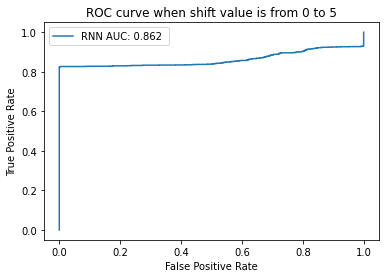

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.23it/s]

100%|██████████| 75/75 [00:00<00:00, 105.51it/s]

100%|██████████| 75/75 [00:00<00:00, 105.44it/s]

100%|██████████| 75/75 [00:00<00:00, 105.36it/s]

100%|██████████| 75/75 [00:00<00:00, 105.36it/s]

100%|██████████| 75/75 [00:00<00:00, 101.99it/s]

100%|██████████| 75/75 [00:00<00:00, 105.19it/s]

100%|██████████| 75/75 [00:00<00:00, 105.37it/s]

100%|██████████| 75/75 [00:00<00:00, 104.25it/s]

100%|██████████| 75/75 [00:00<00:00, 105.17it/s]

100%|██████████| 75/75 [00:00<00:00, 105.34it/s]

100%|██████████| 75/75 [00:00<00:00, 105.26it/s]

100%|██████████| 75/75 [00:00<00:00, 104.13it/s]

100%|██████████| 75/75 [00:00<00:00, 104.86it/s]

100%|██████████| 75/75 [00:00<00:00, 106.03it/s]

100%|██████████| 75/75 [00:00<00:00, 105.74it/s]

100%|██████████| 75/75 [00:00<00:00, 106.23it/s]

100%|██████████| 75/75 [00:00<00:00, 106.08it/s]

100%|██████████| 75/75 [00:00<00:00, 106.16it/s]

100%|██████████| 75/75 [00:00<00:00, 105.91it/s]


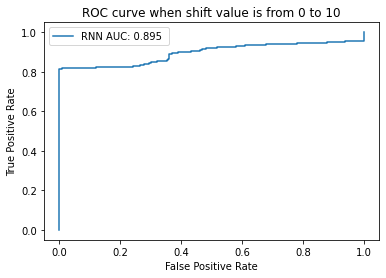

#params 837635



100%|██████████| 75/75 [00:00<00:00, 104.89it/s]

100%|██████████| 75/75 [00:00<00:00, 105.08it/s]

100%|██████████| 75/75 [00:00<00:00, 105.19it/s]

100%|██████████| 75/75 [00:00<00:00, 105.72it/s]

100%|██████████| 75/75 [00:00<00:00, 105.95it/s]

100%|██████████| 75/75 [00:00<00:00, 105.81it/s]

100%|██████████| 75/75 [00:00<00:00, 105.78it/s]

100%|██████████| 75/75 [00:00<00:00, 105.63it/s]

100%|██████████| 75/75 [00:00<00:00, 101.85it/s]

100%|██████████| 75/75 [00:00<00:00, 106.15it/s]

100%|██████████| 75/75 [00:00<00:00, 106.05it/s]

100%|██████████| 75/75 [00:00<00:00, 106.09it/s]

100%|██████████| 75/75 [00:00<00:00, 105.94it/s]

100%|██████████| 75/75 [00:00<00:00, 106.14it/s]

100%|██████████| 75/75 [00:00<00:00, 106.20it/s]

100%|██████████| 75/75 [00:00<00:00, 105.86it/s]

100%|██████████| 75/75 [00:00<00:00, 106.10it/s]

100%|██████████| 75/75 [00:00<00:00, 104.90it/s]

100%|██████████| 75/75 [00:00<00:00, 106.13it/s]

100%|██████████| 75/75 [00:00<00:00, 106.13it/s]


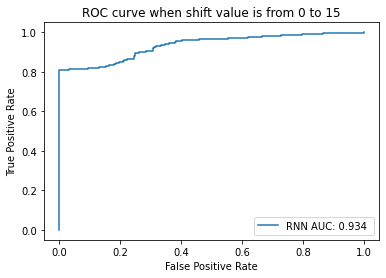

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.99it/s]

100%|██████████| 75/75 [00:00<00:00, 104.32it/s]

100%|██████████| 75/75 [00:00<00:00, 106.32it/s]

100%|██████████| 75/75 [00:00<00:00, 104.55it/s]

100%|██████████| 75/75 [00:00<00:00, 106.11it/s]

100%|██████████| 75/75 [00:00<00:00, 106.30it/s]

100%|██████████| 75/75 [00:00<00:00, 106.40it/s]

100%|██████████| 75/75 [00:00<00:00, 106.35it/s]

100%|██████████| 75/75 [00:00<00:00, 106.24it/s]

100%|██████████| 75/75 [00:00<00:00, 106.41it/s]

100%|██████████| 75/75 [00:00<00:00, 106.38it/s]

100%|██████████| 75/75 [00:00<00:00, 106.41it/s]

100%|██████████| 75/75 [00:00<00:00, 106.36it/s]

100%|██████████| 75/75 [00:00<00:00, 106.47it/s]

100%|██████████| 75/75 [00:00<00:00, 105.41it/s]

100%|██████████| 75/75 [00:00<00:00, 104.70it/s]

100%|██████████| 75/75 [00:00<00:00, 105.42it/s]

100%|██████████| 75/75 [00:00<00:00, 105.78it/s]

100%|██████████| 75/75 [00:00<00:00, 106.47it/s]

100%|██████████| 75/75 [00:00<00:00, 106.57it/s]


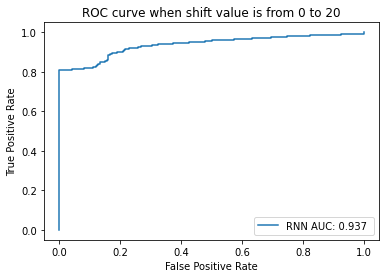

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.68it/s]

100%|██████████| 75/75 [00:00<00:00, 105.51it/s]

100%|██████████| 75/75 [00:00<00:00, 105.03it/s]

100%|██████████| 75/75 [00:00<00:00, 105.44it/s]

100%|██████████| 75/75 [00:00<00:00, 105.42it/s]

100%|██████████| 75/75 [00:00<00:00, 105.52it/s]

100%|██████████| 75/75 [00:00<00:00, 105.46it/s]

100%|██████████| 75/75 [00:00<00:00, 105.52it/s]

100%|██████████| 75/75 [00:00<00:00, 105.05it/s]

100%|██████████| 75/75 [00:00<00:00, 105.32it/s]

100%|██████████| 75/75 [00:00<00:00, 105.50it/s]

100%|██████████| 75/75 [00:00<00:00, 105.32it/s]

100%|██████████| 75/75 [00:00<00:00, 105.20it/s]

100%|██████████| 75/75 [00:00<00:00, 105.35it/s]

100%|██████████| 75/75 [00:00<00:00, 105.23it/s]

100%|██████████| 75/75 [00:00<00:00, 105.18it/s]

100%|██████████| 75/75 [00:00<00:00, 105.33it/s]

100%|██████████| 75/75 [00:00<00:00, 105.35it/s]

100%|██████████| 75/75 [00:00<00:00, 106.46it/s]

100%|██████████| 75/75 [00:00<00:00, 106.35it/s]


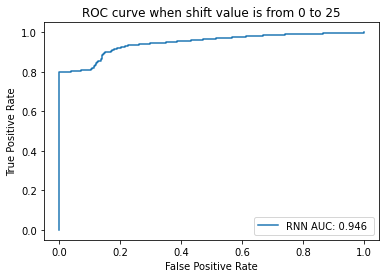

#params 837635



100%|██████████| 75/75 [00:00<00:00, 104.63it/s]

100%|██████████| 75/75 [00:00<00:00, 105.29it/s]

100%|██████████| 75/75 [00:00<00:00, 106.36it/s]

100%|██████████| 75/75 [00:00<00:00, 106.44it/s]

100%|██████████| 75/75 [00:00<00:00, 106.40it/s]

100%|██████████| 75/75 [00:00<00:00, 106.44it/s]

100%|██████████| 75/75 [00:00<00:00, 106.46it/s]

100%|██████████| 75/75 [00:00<00:00, 106.14it/s]

100%|██████████| 75/75 [00:00<00:00, 106.57it/s]

100%|██████████| 75/75 [00:00<00:00, 106.15it/s]

100%|██████████| 75/75 [00:00<00:00, 101.48it/s]

100%|██████████| 75/75 [00:00<00:00, 106.25it/s]

100%|██████████| 75/75 [00:00<00:00, 106.14it/s]

100%|██████████| 75/75 [00:00<00:00, 106.37it/s]

100%|██████████| 75/75 [00:00<00:00, 106.47it/s]

100%|██████████| 75/75 [00:00<00:00, 106.46it/s]

100%|██████████| 75/75 [00:00<00:00, 106.24it/s]

100%|██████████| 75/75 [00:00<00:00, 106.37it/s]

100%|██████████| 75/75 [00:00<00:00, 106.29it/s]

100%|██████████| 75/75 [00:00<00:00, 106.52it/s]


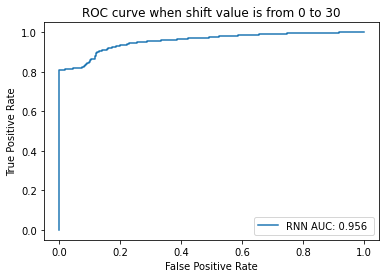

#params 837635



100%|██████████| 75/75 [00:00<00:00, 106.17it/s]

100%|██████████| 75/75 [00:00<00:00, 106.46it/s]

100%|██████████| 75/75 [00:00<00:00, 106.55it/s]

100%|██████████| 75/75 [00:00<00:00, 106.37it/s]

100%|██████████| 75/75 [00:00<00:00, 102.69it/s]

100%|██████████| 75/75 [00:00<00:00, 106.37it/s]

100%|██████████| 75/75 [00:00<00:00, 106.48it/s]

100%|██████████| 75/75 [00:00<00:00, 106.07it/s]

100%|██████████| 75/75 [00:00<00:00, 106.49it/s]

100%|██████████| 75/75 [00:00<00:00, 106.51it/s]

100%|██████████| 75/75 [00:00<00:00, 106.21it/s]

100%|██████████| 75/75 [00:00<00:00, 106.36it/s]

100%|██████████| 75/75 [00:00<00:00, 106.25it/s]

100%|██████████| 75/75 [00:00<00:00, 106.49it/s]

100%|██████████| 75/75 [00:00<00:00, 106.25it/s]

100%|██████████| 75/75 [00:00<00:00, 106.42it/s]

100%|██████████| 75/75 [00:00<00:00, 105.28it/s]

100%|██████████| 75/75 [00:00<00:00, 101.21it/s]

100%|██████████| 75/75 [00:00<00:00, 105.33it/s]

100%|██████████| 75/75 [00:00<00:00, 106.28it/s]


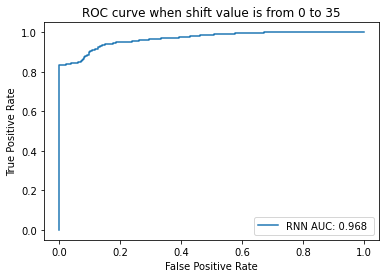

#params 837635



100%|██████████| 75/75 [00:00<00:00, 106.17it/s]

100%|██████████| 75/75 [00:00<00:00, 105.88it/s]

100%|██████████| 75/75 [00:00<00:00, 105.52it/s]

100%|██████████| 75/75 [00:00<00:00, 106.22it/s]

100%|██████████| 75/75 [00:00<00:00, 106.41it/s]

100%|██████████| 75/75 [00:00<00:00, 106.27it/s]

100%|██████████| 75/75 [00:00<00:00, 106.18it/s]

100%|██████████| 75/75 [00:00<00:00, 106.40it/s]

100%|██████████| 75/75 [00:00<00:00, 106.05it/s]

100%|██████████| 75/75 [00:00<00:00, 106.38it/s]

100%|██████████| 75/75 [00:00<00:00, 106.42it/s]

100%|██████████| 75/75 [00:00<00:00, 99.63it/s] 

100%|██████████| 75/75 [00:00<00:00, 106.26it/s]

100%|██████████| 75/75 [00:00<00:00, 106.33it/s]

100%|██████████| 75/75 [00:00<00:00, 106.29it/s]

100%|██████████| 75/75 [00:00<00:00, 106.20it/s]

100%|██████████| 75/75 [00:00<00:00, 106.20it/s]

100%|██████████| 75/75 [00:00<00:00, 106.36it/s]

100%|██████████| 75/75 [00:00<00:00, 106.31it/s]

100%|██████████| 75/75 [00:00<00:00, 76.80it/s]



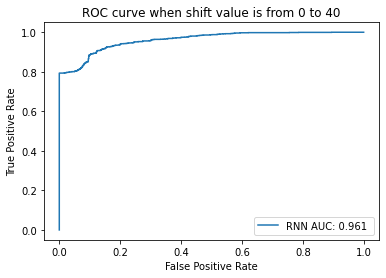

#params 837635



100%|██████████| 75/75 [00:00<00:00, 106.16it/s]

100%|██████████| 75/75 [00:00<00:00, 101.55it/s][A

100%|██████████| 75/75 [00:00<00:00, 106.31it/s]

100%|██████████| 75/75 [00:00<00:00, 105.81it/s]

100%|██████████| 75/75 [00:00<00:00, 106.12it/s]

100%|██████████| 75/75 [00:00<00:00, 105.89it/s]

100%|██████████| 75/75 [00:00<00:00, 106.12it/s]

100%|██████████| 75/75 [00:00<00:00, 106.25it/s]

100%|██████████| 75/75 [00:00<00:00, 106.14it/s]

100%|██████████| 75/75 [00:00<00:00, 106.19it/s]

100%|██████████| 75/75 [00:00<00:00, 105.94it/s]

100%|██████████| 75/75 [00:00<00:00, 105.97it/s]

100%|██████████| 75/75 [00:00<00:00, 104.57it/s]

100%|██████████| 75/75 [00:00<00:00, 105.21it/s]

100%|██████████| 75/75 [00:00<00:00, 104.60it/s]

100%|██████████| 75/75 [00:00<00:00, 99.48it/s]

100%|██████████| 75/75 [00:00<00:00, 104.83it/s]

100%|██████████| 75/75 [00:00<00:00, 105.13it/s]

100%|██████████| 75/75 [00:00<00:00, 105.07it/s]

100%|██████████| 75/75 [00:00<00:00, 104.82it/s]

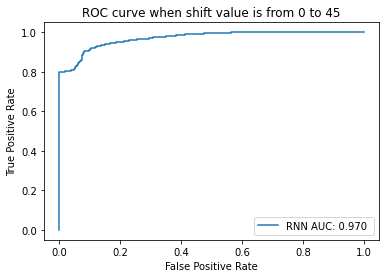

#params 837635



100%|██████████| 75/75 [00:00<00:00, 106.06it/s]

100%|██████████| 75/75 [00:00<00:00, 106.00it/s]

100%|██████████| 75/75 [00:00<00:00, 106.09it/s]

100%|██████████| 75/75 [00:00<00:00, 106.07it/s]

100%|██████████| 75/75 [00:00<00:00, 106.17it/s]

100%|██████████| 75/75 [00:00<00:00, 106.04it/s]

100%|██████████| 75/75 [00:00<00:00, 106.00it/s]

100%|██████████| 75/75 [00:00<00:00, 105.99it/s]

100%|██████████| 75/75 [00:00<00:00, 95.59it/s] 

100%|██████████| 75/75 [00:00<00:00, 105.65it/s]

100%|██████████| 75/75 [00:00<00:00, 105.45it/s]

100%|██████████| 75/75 [00:00<00:00, 106.09it/s]

100%|██████████| 75/75 [00:00<00:00, 105.81it/s]

100%|██████████| 75/75 [00:00<00:00, 106.08it/s]

100%|██████████| 75/75 [00:00<00:00, 106.02it/s]

100%|██████████| 75/75 [00:00<00:00, 105.95it/s]

100%|██████████| 75/75 [00:00<00:00, 105.89it/s]

100%|██████████| 75/75 [00:00<00:00, 105.83it/s]

100%|██████████| 75/75 [00:00<00:00, 105.26it/s]

100%|██████████| 75/75 [00:00<00:00, 105.08it/s]


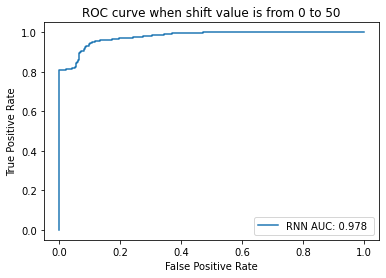

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.82it/s]

100%|██████████| 75/75 [00:00<00:00, 105.79it/s]

100%|██████████| 75/75 [00:00<00:00, 105.81it/s]

100%|██████████| 75/75 [00:00<00:00, 105.70it/s]

100%|██████████| 75/75 [00:00<00:00, 105.26it/s]

100%|██████████| 75/75 [00:00<00:00, 105.19it/s]

100%|██████████| 75/75 [00:00<00:00, 105.49it/s]

100%|██████████| 75/75 [00:00<00:00, 105.76it/s]

100%|██████████| 75/75 [00:00<00:00, 105.65it/s]

100%|██████████| 75/75 [00:00<00:00, 105.64it/s]

100%|██████████| 75/75 [00:00<00:00, 105.50it/s]

100%|██████████| 75/75 [00:00<00:00, 105.72it/s]

100%|██████████| 75/75 [00:00<00:00, 101.28it/s]

100%|██████████| 75/75 [00:00<00:00, 105.55it/s]

100%|██████████| 75/75 [00:00<00:00, 105.75it/s]

100%|██████████| 75/75 [00:00<00:00, 104.93it/s]

100%|██████████| 75/75 [00:00<00:00, 105.77it/s]

100%|██████████| 75/75 [00:00<00:00, 105.66it/s]

100%|██████████| 75/75 [00:00<00:00, 105.51it/s]

100%|██████████| 75/75 [00:00<00:00, 105.67it/s]


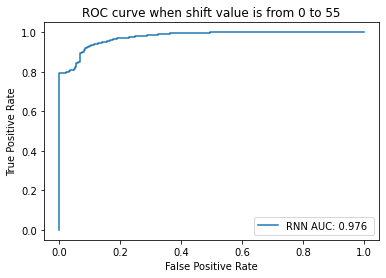

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.77it/s]

100%|██████████| 75/75 [00:00<00:00, 105.66it/s]

100%|██████████| 75/75 [00:00<00:00, 105.60it/s]

100%|██████████| 75/75 [00:00<00:00, 105.65it/s]

100%|██████████| 75/75 [00:00<00:00, 102.02it/s]

100%|██████████| 75/75 [00:00<00:00, 105.57it/s]

100%|██████████| 75/75 [00:00<00:00, 105.55it/s]

100%|██████████| 75/75 [00:00<00:00, 99.62it/s] 

100%|██████████| 75/75 [00:00<00:00, 105.16it/s]

100%|██████████| 75/75 [00:00<00:00, 105.32it/s]

100%|██████████| 75/75 [00:00<00:00, 104.61it/s]

100%|██████████| 75/75 [00:00<00:00, 105.52it/s]

100%|██████████| 75/75 [00:00<00:00, 105.47it/s]

100%|██████████| 75/75 [00:00<00:00, 105.64it/s]

100%|██████████| 75/75 [00:00<00:00, 105.40it/s]

100%|██████████| 75/75 [00:00<00:00, 105.38it/s]

100%|██████████| 75/75 [00:00<00:00, 105.49it/s]

100%|██████████| 75/75 [00:00<00:00, 105.43it/s]

100%|██████████| 75/75 [00:00<00:00, 104.53it/s]

100%|██████████| 75/75 [00:00<00:00, 105.69it/s]


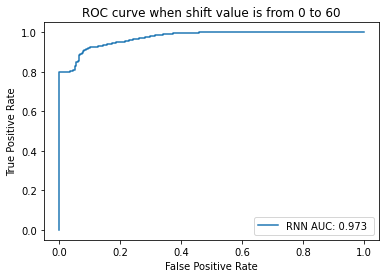

#params 837635



100%|██████████| 75/75 [00:00<00:00, 106.27it/s]

100%|██████████| 75/75 [00:00<00:00, 106.10it/s]

100%|██████████| 75/75 [00:00<00:00, 106.34it/s]

100%|██████████| 75/75 [00:00<00:00, 106.56it/s]

100%|██████████| 75/75 [00:00<00:00, 106.53it/s]

100%|██████████| 75/75 [00:00<00:00, 106.48it/s]

100%|██████████| 75/75 [00:00<00:00, 106.06it/s]

100%|██████████| 75/75 [00:00<00:00, 106.45it/s]

100%|██████████| 75/75 [00:00<00:00, 106.44it/s]

100%|██████████| 75/75 [00:00<00:00, 106.53it/s]

100%|██████████| 75/75 [00:00<00:00, 106.46it/s]

100%|██████████| 75/75 [00:00<00:00, 106.34it/s]

100%|██████████| 75/75 [00:00<00:00, 106.53it/s]

100%|██████████| 75/75 [00:00<00:00, 106.38it/s]

100%|██████████| 75/75 [00:00<00:00, 106.28it/s]

100%|██████████| 75/75 [00:00<00:00, 106.36it/s]

100%|██████████| 75/75 [00:00<00:00, 106.51it/s]

100%|██████████| 75/75 [00:00<00:00, 106.37it/s]

100%|██████████| 75/75 [00:00<00:00, 106.45it/s]

100%|██████████| 75/75 [00:00<00:00, 106.47it/s]


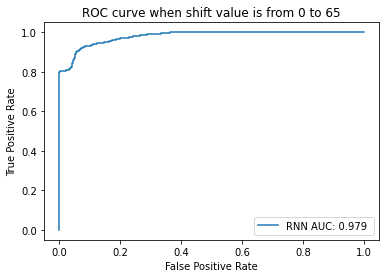

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.40it/s]

100%|██████████| 75/75 [00:00<00:00, 104.86it/s]

100%|██████████| 75/75 [00:00<00:00, 105.50it/s]

100%|██████████| 75/75 [00:00<00:00, 105.45it/s]

100%|██████████| 75/75 [00:00<00:00, 105.60it/s]

100%|██████████| 75/75 [00:00<00:00, 105.55it/s]

100%|██████████| 75/75 [00:00<00:00, 105.43it/s]

100%|██████████| 75/75 [00:00<00:00, 105.46it/s]

100%|██████████| 75/75 [00:00<00:00, 105.03it/s]

100%|██████████| 75/75 [00:00<00:00, 105.27it/s]

100%|██████████| 75/75 [00:00<00:00, 105.37it/s]

100%|██████████| 75/75 [00:00<00:00, 105.31it/s]

100%|██████████| 75/75 [00:00<00:00, 105.44it/s]

100%|██████████| 75/75 [00:00<00:00, 91.81it/s] 

100%|██████████| 75/75 [00:00<00:00, 105.16it/s]

100%|██████████| 75/75 [00:00<00:00, 105.17it/s]

100%|██████████| 75/75 [00:00<00:00, 105.26it/s]

100%|██████████| 75/75 [00:00<00:00, 105.42it/s]

100%|██████████| 75/75 [00:00<00:00, 105.11it/s]

100%|██████████| 75/75 [00:00<00:00, 105.18it/s]


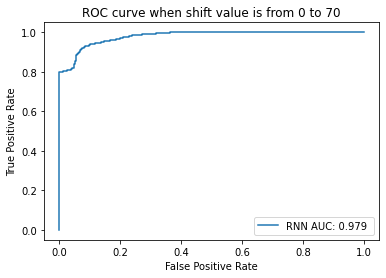

#params 837635



100%|██████████| 75/75 [00:00<00:00, 104.94it/s]

100%|██████████| 75/75 [00:00<00:00, 105.13it/s]

100%|██████████| 75/75 [00:00<00:00, 105.22it/s]

100%|██████████| 75/75 [00:00<00:00, 105.34it/s]

100%|██████████| 75/75 [00:00<00:00, 104.26it/s]

100%|██████████| 75/75 [00:00<00:00, 104.94it/s]

100%|██████████| 75/75 [00:00<00:00, 104.43it/s]

100%|██████████| 75/75 [00:00<00:00, 100.60it/s]

100%|██████████| 75/75 [00:00<00:00, 105.22it/s]

100%|██████████| 75/75 [00:00<00:00, 105.18it/s]

100%|██████████| 75/75 [00:00<00:00, 105.17it/s]

100%|██████████| 75/75 [00:00<00:00, 104.75it/s]

100%|██████████| 75/75 [00:00<00:00, 105.10it/s]

100%|██████████| 75/75 [00:00<00:00, 105.21it/s]

100%|██████████| 75/75 [00:00<00:00, 105.35it/s]

100%|██████████| 75/75 [00:00<00:00, 104.77it/s]

100%|██████████| 75/75 [00:00<00:00, 105.36it/s]

100%|██████████| 75/75 [00:00<00:00, 104.98it/s]

100%|██████████| 75/75 [00:00<00:00, 105.16it/s]

100%|██████████| 75/75 [00:00<00:00, 105.18it/s]


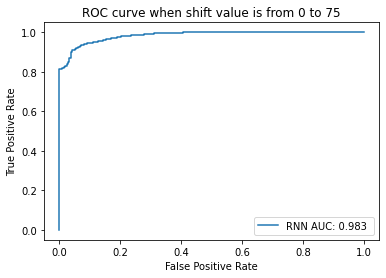

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.14it/s]

100%|██████████| 75/75 [00:00<00:00, 105.02it/s]

100%|██████████| 75/75 [00:00<00:00, 105.20it/s]

100%|██████████| 75/75 [00:00<00:00, 104.93it/s]

100%|██████████| 75/75 [00:00<00:00, 105.10it/s]

100%|██████████| 75/75 [00:00<00:00, 104.83it/s]

100%|██████████| 75/75 [00:00<00:00, 104.60it/s]

100%|██████████| 75/75 [00:00<00:00, 105.12it/s]

100%|██████████| 75/75 [00:00<00:00, 105.01it/s]

100%|██████████| 75/75 [00:00<00:00, 104.92it/s]

100%|██████████| 75/75 [00:00<00:00, 83.12it/s]

100%|██████████| 75/75 [00:00<00:00, 105.11it/s]

100%|██████████| 75/75 [00:00<00:00, 104.96it/s]

100%|██████████| 75/75 [00:00<00:00, 105.22it/s]

100%|██████████| 75/75 [00:00<00:00, 105.20it/s]

100%|██████████| 75/75 [00:00<00:00, 103.76it/s]

100%|██████████| 75/75 [00:00<00:00, 105.01it/s]

100%|██████████| 75/75 [00:00<00:00, 105.00it/s]

100%|██████████| 75/75 [00:00<00:00, 105.11it/s]

100%|██████████| 75/75 [00:00<00:00, 106.27it/s]



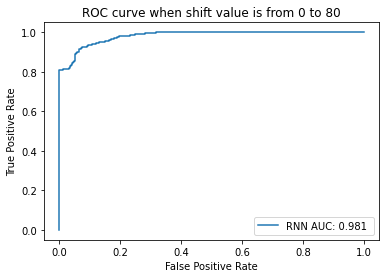

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.25it/s]

100%|██████████| 75/75 [00:00<00:00, 106.25it/s]

100%|██████████| 75/75 [00:00<00:00, 106.20it/s]

100%|██████████| 75/75 [00:00<00:00, 100.56it/s][A

100%|██████████| 75/75 [00:00<00:00, 106.27it/s]

100%|██████████| 75/75 [00:00<00:00, 106.23it/s]

100%|██████████| 75/75 [00:00<00:00, 106.05it/s]

100%|██████████| 75/75 [00:00<00:00, 105.90it/s]

100%|██████████| 75/75 [00:00<00:00, 106.05it/s]

100%|██████████| 75/75 [00:00<00:00, 106.24it/s]

100%|██████████| 75/75 [00:00<00:00, 92.01it/s] 

100%|██████████| 75/75 [00:00<00:00, 105.94it/s]

100%|██████████| 75/75 [00:00<00:00, 105.78it/s]

100%|██████████| 75/75 [00:00<00:00, 105.99it/s]

100%|██████████| 75/75 [00:00<00:00, 106.14it/s]

100%|██████████| 75/75 [00:00<00:00, 104.48it/s]

100%|██████████| 75/75 [00:00<00:00, 105.17it/s]

100%|██████████| 75/75 [00:00<00:00, 105.10it/s]

100%|██████████| 75/75 [00:00<00:00, 105.14it/s]

100%|██████████| 75/75 [00:00<00:00, 106.07it/s

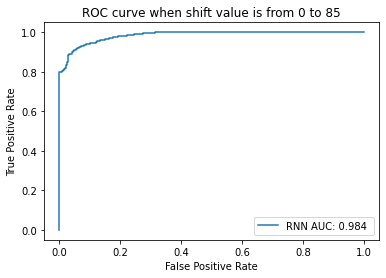

#params 837635



100%|██████████| 75/75 [00:00<00:00, 103.68it/s]

100%|██████████| 75/75 [00:00<00:00, 104.91it/s]

100%|██████████| 75/75 [00:00<00:00, 105.01it/s]

100%|██████████| 75/75 [00:00<00:00, 105.02it/s]

100%|██████████| 75/75 [00:00<00:00, 92.19it/s]

100%|██████████| 75/75 [00:00<00:00, 104.94it/s]

100%|██████████| 75/75 [00:00<00:00, 105.04it/s]

100%|██████████| 75/75 [00:00<00:00, 105.01it/s]

100%|██████████| 75/75 [00:00<00:00, 105.04it/s]

100%|██████████| 75/75 [00:00<00:00, 105.02it/s]

100%|██████████| 75/75 [00:00<00:00, 105.17it/s]

100%|██████████| 75/75 [00:00<00:00, 89.69it/s]

100%|██████████| 75/75 [00:00<00:00, 104.98it/s]

100%|██████████| 75/75 [00:00<00:00, 105.14it/s]

100%|██████████| 75/75 [00:00<00:00, 105.17it/s]

100%|██████████| 75/75 [00:00<00:00, 105.29it/s]

100%|██████████| 75/75 [00:00<00:00, 105.21it/s]

100%|██████████| 75/75 [00:00<00:00, 105.11it/s]

100%|██████████| 75/75 [00:00<00:00, 105.16it/s]

100%|██████████| 75/75 [00:00<00:00, 105.02it/s]

1

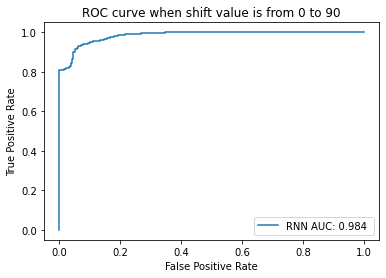

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.00it/s]

100%|██████████| 75/75 [00:00<00:00, 105.10it/s]

100%|██████████| 75/75 [00:00<00:00, 105.33it/s]

100%|██████████| 75/75 [00:00<00:00, 105.29it/s]

100%|██████████| 75/75 [00:00<00:00, 105.34it/s]

100%|██████████| 75/75 [00:00<00:00, 104.85it/s]

100%|██████████| 75/75 [00:00<00:00, 105.23it/s]

100%|██████████| 75/75 [00:00<00:00, 105.38it/s]

100%|██████████| 75/75 [00:00<00:00, 105.28it/s]

100%|██████████| 75/75 [00:00<00:00, 105.53it/s]

100%|██████████| 75/75 [00:00<00:00, 105.18it/s]

100%|██████████| 75/75 [00:00<00:00, 105.28it/s]

100%|██████████| 75/75 [00:00<00:00, 105.45it/s]

100%|██████████| 75/75 [00:00<00:00, 105.09it/s]

100%|██████████| 75/75 [00:00<00:00, 105.43it/s]

100%|██████████| 75/75 [00:00<00:00, 105.21it/s]

100%|██████████| 75/75 [00:00<00:00, 105.08it/s]

100%|██████████| 75/75 [00:00<00:00, 105.13it/s]

100%|██████████| 75/75 [00:00<00:00, 105.40it/s]

100%|██████████| 75/75 [00:00<00:00, 105.25it/s]


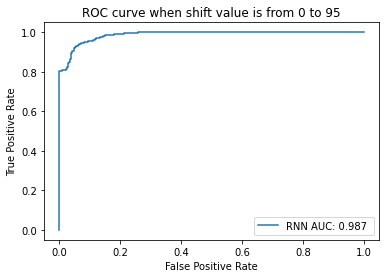

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.10it/s]

100%|██████████| 75/75 [00:00<00:00, 105.18it/s]

100%|██████████| 75/75 [00:00<00:00, 105.16it/s]

100%|██████████| 75/75 [00:00<00:00, 104.99it/s]

100%|██████████| 75/75 [00:00<00:00, 95.06it/s]

100%|██████████| 75/75 [00:00<00:00, 105.27it/s]

100%|██████████| 75/75 [00:00<00:00, 105.15it/s]

100%|██████████| 75/75 [00:00<00:00, 105.22it/s]

100%|██████████| 75/75 [00:00<00:00, 105.23it/s]

100%|██████████| 75/75 [00:00<00:00, 105.07it/s]

100%|██████████| 75/75 [00:00<00:00, 105.10it/s]

100%|██████████| 75/75 [00:00<00:00, 104.76it/s]

100%|██████████| 75/75 [00:00<00:00, 105.15it/s]

100%|██████████| 75/75 [00:00<00:00, 104.96it/s]

100%|██████████| 75/75 [00:00<00:00, 105.23it/s]

100%|██████████| 75/75 [00:00<00:00, 105.07it/s]

100%|██████████| 75/75 [00:00<00:00, 105.46it/s]

100%|██████████| 75/75 [00:00<00:00, 106.23it/s]

100%|██████████| 75/75 [00:00<00:00, 105.92it/s]

100%|██████████| 75/75 [00:00<00:00, 106.01it/s]



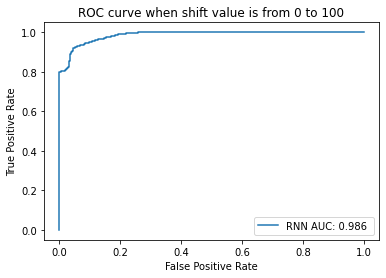

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.22it/s]

100%|██████████| 75/75 [00:00<00:00, 105.15it/s]

100%|██████████| 75/75 [00:00<00:00, 105.08it/s]

100%|██████████| 75/75 [00:00<00:00, 105.03it/s]

100%|██████████| 75/75 [00:00<00:00, 105.19it/s]

100%|██████████| 75/75 [00:00<00:00, 105.23it/s]

100%|██████████| 75/75 [00:00<00:00, 105.02it/s]

100%|██████████| 75/75 [00:00<00:00, 105.15it/s]

100%|██████████| 75/75 [00:00<00:00, 105.26it/s]

100%|██████████| 75/75 [00:00<00:00, 105.28it/s]

100%|██████████| 75/75 [00:00<00:00, 105.14it/s]

100%|██████████| 75/75 [00:00<00:00, 105.14it/s]

100%|██████████| 75/75 [00:00<00:00, 105.02it/s]

100%|██████████| 75/75 [00:00<00:00, 105.08it/s]

100%|██████████| 75/75 [00:00<00:00, 104.67it/s]

100%|██████████| 75/75 [00:00<00:00, 105.02it/s]

100%|██████████| 75/75 [00:00<00:00, 104.99it/s]

100%|██████████| 75/75 [00:00<00:00, 105.17it/s]

100%|██████████| 75/75 [00:00<00:00, 105.09it/s]

100%|██████████| 75/75 [00:00<00:00, 105.29it/s]


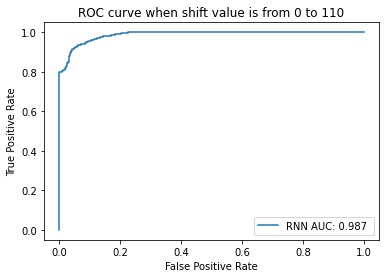

#params 837635



100%|██████████| 75/75 [00:00<00:00, 103.69it/s]

100%|██████████| 75/75 [00:00<00:00, 105.10it/s]

100%|██████████| 75/75 [00:00<00:00, 104.63it/s]

100%|██████████| 75/75 [00:00<00:00, 105.20it/s]

100%|██████████| 75/75 [00:00<00:00, 93.92it/s]

100%|██████████| 75/75 [00:00<00:00, 105.35it/s]

100%|██████████| 75/75 [00:00<00:00, 105.27it/s]

100%|██████████| 75/75 [00:00<00:00, 105.26it/s]

100%|██████████| 75/75 [00:00<00:00, 105.15it/s]

100%|██████████| 75/75 [00:00<00:00, 104.17it/s]

100%|██████████| 75/75 [00:00<00:00, 105.02it/s]

100%|██████████| 75/75 [00:00<00:00, 105.11it/s]

100%|██████████| 75/75 [00:00<00:00, 104.94it/s]

100%|██████████| 75/75 [00:00<00:00, 105.08it/s]

100%|██████████| 75/75 [00:00<00:00, 105.02it/s]

100%|██████████| 75/75 [00:00<00:00, 104.76it/s]

100%|██████████| 75/75 [00:00<00:00, 106.15it/s]

100%|██████████| 75/75 [00:00<00:00, 106.11it/s]

100%|██████████| 75/75 [00:00<00:00, 106.00it/s]

100%|██████████| 75/75 [00:00<00:00, 105.69it/s]



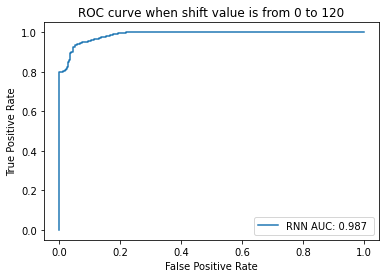

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.23it/s]

100%|██████████| 75/75 [00:00<00:00, 105.20it/s]

100%|██████████| 75/75 [00:00<00:00, 105.25it/s]

100%|██████████| 75/75 [00:00<00:00, 105.25it/s]

100%|██████████| 75/75 [00:00<00:00, 105.30it/s]

100%|██████████| 75/75 [00:00<00:00, 104.88it/s]

100%|██████████| 75/75 [00:00<00:00, 105.19it/s]

100%|██████████| 75/75 [00:00<00:00, 105.14it/s]

100%|██████████| 75/75 [00:00<00:00, 105.17it/s]

100%|██████████| 75/75 [00:00<00:00, 105.27it/s]

100%|██████████| 75/75 [00:00<00:00, 105.22it/s]

100%|██████████| 75/75 [00:00<00:00, 104.98it/s]

100%|██████████| 75/75 [00:00<00:00, 105.04it/s]

100%|██████████| 75/75 [00:00<00:00, 105.15it/s]

100%|██████████| 75/75 [00:00<00:00, 105.14it/s]

100%|██████████| 75/75 [00:00<00:00, 105.11it/s]

100%|██████████| 75/75 [00:00<00:00, 106.14it/s]

100%|██████████| 75/75 [00:00<00:00, 106.27it/s]

100%|██████████| 75/75 [00:00<00:00, 106.30it/s]

100%|██████████| 75/75 [00:00<00:00, 106.42it/s]


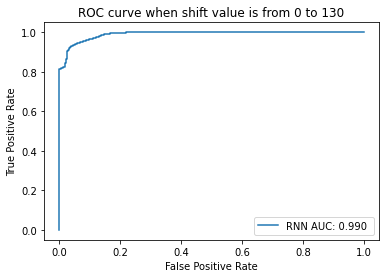

#params 837635



100%|██████████| 75/75 [00:00<00:00, 106.19it/s]

100%|██████████| 75/75 [00:00<00:00, 106.17it/s]

100%|██████████| 75/75 [00:00<00:00, 106.19it/s]

100%|██████████| 75/75 [00:00<00:00, 105.93it/s]

100%|██████████| 75/75 [00:00<00:00, 101.54it/s]

100%|██████████| 75/75 [00:00<00:00, 106.27it/s]

100%|██████████| 75/75 [00:00<00:00, 106.16it/s]

100%|██████████| 75/75 [00:00<00:00, 106.19it/s]

100%|██████████| 75/75 [00:00<00:00, 106.12it/s]

100%|██████████| 75/75 [00:00<00:00, 106.19it/s]

100%|██████████| 75/75 [00:00<00:00, 105.94it/s]

100%|██████████| 75/75 [00:00<00:00, 105.44it/s]

100%|██████████| 75/75 [00:00<00:00, 105.94it/s]

100%|██████████| 75/75 [00:00<00:00, 106.26it/s]

100%|██████████| 75/75 [00:00<00:00, 106.03it/s]

100%|██████████| 75/75 [00:00<00:00, 106.12it/s]

100%|██████████| 75/75 [00:00<00:00, 106.22it/s]

100%|██████████| 75/75 [00:00<00:00, 106.26it/s]

100%|██████████| 75/75 [00:00<00:00, 106.21it/s]

100%|██████████| 75/75 [00:00<00:00, 106.15it/s]


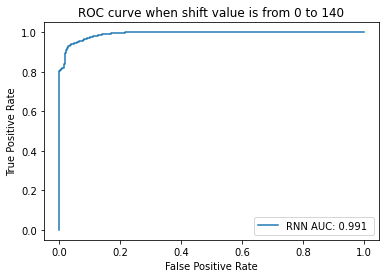

#params 837635



100%|██████████| 75/75 [00:00<00:00, 104.99it/s]

100%|██████████| 75/75 [00:00<00:00, 105.10it/s]

100%|██████████| 75/75 [00:00<00:00, 105.15it/s]

100%|██████████| 75/75 [00:00<00:00, 105.21it/s]

100%|██████████| 75/75 [00:00<00:00, 105.16it/s]

100%|██████████| 75/75 [00:00<00:00, 105.17it/s]

100%|██████████| 75/75 [00:00<00:00, 105.16it/s]

100%|██████████| 75/75 [00:00<00:00, 105.36it/s]

100%|██████████| 75/75 [00:00<00:00, 105.27it/s]

100%|██████████| 75/75 [00:00<00:00, 105.32it/s]

100%|██████████| 75/75 [00:00<00:00, 105.10it/s]

100%|██████████| 75/75 [00:00<00:00, 105.01it/s]

100%|██████████| 75/75 [00:00<00:00, 105.32it/s]

100%|██████████| 75/75 [00:00<00:00, 105.01it/s]

100%|██████████| 75/75 [00:00<00:00, 105.06it/s]

100%|██████████| 75/75 [00:00<00:00, 104.98it/s]

100%|██████████| 75/75 [00:00<00:00, 105.04it/s]

100%|██████████| 75/75 [00:00<00:00, 104.80it/s]

100%|██████████| 75/75 [00:00<00:00, 105.11it/s]

100%|██████████| 75/75 [00:00<00:00, 104.92it/s]


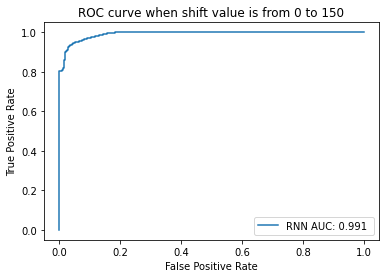

#params 837635



100%|██████████| 75/75 [00:00<00:00, 102.83it/s]

100%|██████████| 75/75 [00:00<00:00, 104.98it/s]

100%|██████████| 75/75 [00:00<00:00, 104.98it/s]

100%|██████████| 75/75 [00:00<00:00, 100.47it/s]

100%|██████████| 75/75 [00:00<00:00, 99.69it/s] 

100%|██████████| 75/75 [00:00<00:00, 105.09it/s]

100%|██████████| 75/75 [00:00<00:00, 105.03it/s]

100%|██████████| 75/75 [00:00<00:00, 105.03it/s]

100%|██████████| 75/75 [00:00<00:00, 105.02it/s]

100%|██████████| 75/75 [00:00<00:00, 101.65it/s]

100%|██████████| 75/75 [00:00<00:00, 104.88it/s]

100%|██████████| 75/75 [00:00<00:00, 105.02it/s]

100%|██████████| 75/75 [00:00<00:00, 105.02it/s]

100%|██████████| 75/75 [00:00<00:00, 104.94it/s]

100%|██████████| 75/75 [00:00<00:00, 105.95it/s]

100%|██████████| 75/75 [00:00<00:00, 104.96it/s]

100%|██████████| 75/75 [00:00<00:00, 105.12it/s]

100%|██████████| 75/75 [00:00<00:00, 79.01it/s]

100%|██████████| 75/75 [00:00<00:00, 105.30it/s]

100%|██████████| 75/75 [00:00<00:00, 104.64it/s]



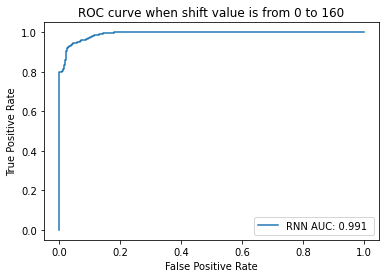

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.22it/s]

100%|██████████| 75/75 [00:00<00:00, 104.88it/s]

100%|██████████| 75/75 [00:00<00:00, 105.06it/s]

100%|██████████| 75/75 [00:00<00:00, 104.89it/s]

100%|██████████| 75/75 [00:00<00:00, 104.87it/s]

100%|██████████| 75/75 [00:00<00:00, 92.19it/s] 

100%|██████████| 75/75 [00:00<00:00, 104.96it/s]

100%|██████████| 75/75 [00:00<00:00, 105.53it/s]

100%|██████████| 75/75 [00:00<00:00, 105.84it/s]

100%|██████████| 75/75 [00:00<00:00, 105.85it/s]

100%|██████████| 75/75 [00:00<00:00, 105.76it/s]

100%|██████████| 75/75 [00:00<00:00, 105.82it/s]

100%|██████████| 75/75 [00:00<00:00, 105.63it/s]

100%|██████████| 75/75 [00:00<00:00, 105.54it/s]

100%|██████████| 75/75 [00:00<00:00, 105.81it/s]

100%|██████████| 75/75 [00:00<00:00, 105.99it/s]

100%|██████████| 75/75 [00:00<00:00, 105.40it/s]

100%|██████████| 75/75 [00:00<00:00, 105.73it/s]

100%|██████████| 75/75 [00:00<00:00, 105.89it/s]

100%|██████████| 75/75 [00:00<00:00, 101.61it/s]


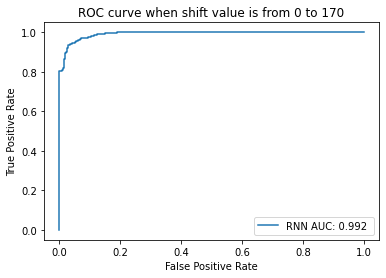

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.96it/s]

100%|██████████| 75/75 [00:00<00:00, 106.07it/s]

100%|██████████| 75/75 [00:00<00:00, 91.40it/s]

100%|██████████| 75/75 [00:00<00:00, 106.13it/s]

100%|██████████| 75/75 [00:00<00:00, 106.04it/s]

100%|██████████| 75/75 [00:00<00:00, 89.35it/s] 

100%|██████████| 75/75 [00:00<00:00, 105.02it/s]

100%|██████████| 75/75 [00:00<00:00, 104.38it/s]

100%|██████████| 75/75 [00:00<00:00, 104.76it/s]

100%|██████████| 75/75 [00:00<00:00, 104.82it/s]

100%|██████████| 75/75 [00:00<00:00, 104.82it/s]

100%|██████████| 75/75 [00:00<00:00, 104.97it/s]

100%|██████████| 75/75 [00:00<00:00, 104.93it/s]

100%|██████████| 75/75 [00:00<00:00, 104.95it/s]

100%|██████████| 75/75 [00:00<00:00, 104.86it/s]

100%|██████████| 75/75 [00:00<00:00, 105.01it/s]

100%|██████████| 75/75 [00:00<00:00, 104.95it/s]

100%|██████████| 75/75 [00:00<00:00, 104.92it/s]

100%|██████████| 75/75 [00:00<00:00, 104.48it/s]

100%|██████████| 75/75 [00:00<00:00, 105.02it/s]



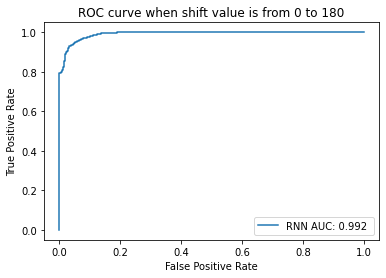

#params 837635



100%|██████████| 75/75 [00:00<00:00, 104.95it/s]

100%|██████████| 75/75 [00:00<00:00, 104.90it/s]

100%|██████████| 75/75 [00:00<00:00, 105.05it/s]

100%|██████████| 75/75 [00:00<00:00, 105.01it/s]

100%|██████████| 75/75 [00:00<00:00, 105.07it/s]

100%|██████████| 75/75 [00:00<00:00, 105.08it/s]

100%|██████████| 75/75 [00:00<00:00, 105.19it/s]

100%|██████████| 75/75 [00:00<00:00, 104.74it/s]

100%|██████████| 75/75 [00:00<00:00, 105.03it/s]

100%|██████████| 75/75 [00:00<00:00, 105.11it/s]

100%|██████████| 75/75 [00:00<00:00, 100.17it/s]

100%|██████████| 75/75 [00:00<00:00, 105.04it/s]

100%|██████████| 75/75 [00:00<00:00, 105.00it/s]

100%|██████████| 75/75 [00:00<00:00, 104.97it/s]

100%|██████████| 75/75 [00:00<00:00, 104.99it/s]

100%|██████████| 75/75 [00:00<00:00, 104.64it/s]

100%|██████████| 75/75 [00:00<00:00, 104.41it/s]

100%|██████████| 75/75 [00:00<00:00, 104.85it/s]

100%|██████████| 75/75 [00:00<00:00, 88.50it/s]

100%|██████████| 75/75 [00:00<00:00, 104.96it/s]



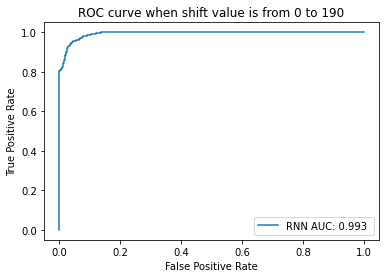

#params 837635



100%|██████████| 75/75 [00:00<00:00, 106.05it/s]

100%|██████████| 75/75 [00:00<00:00, 105.68it/s]

100%|██████████| 75/75 [00:00<00:00, 105.82it/s]

100%|██████████| 75/75 [00:00<00:00, 105.73it/s]

100%|██████████| 75/75 [00:00<00:00, 105.74it/s]

100%|██████████| 75/75 [00:00<00:00, 105.71it/s]

100%|██████████| 75/75 [00:00<00:00, 105.81it/s]

100%|██████████| 75/75 [00:00<00:00, 100.74it/s]

100%|██████████| 75/75 [00:00<00:00, 104.74it/s]

100%|██████████| 75/75 [00:00<00:00, 104.81it/s]

100%|██████████| 75/75 [00:00<00:00, 105.12it/s]

100%|██████████| 75/75 [00:00<00:00, 105.01it/s]

100%|██████████| 75/75 [00:00<00:00, 104.75it/s]

100%|██████████| 75/75 [00:00<00:00, 104.58it/s]

100%|██████████| 75/75 [00:00<00:00, 104.17it/s]

100%|██████████| 75/75 [00:00<00:00, 104.69it/s]

100%|██████████| 75/75 [00:00<00:00, 104.94it/s]

100%|██████████| 75/75 [00:00<00:00, 105.05it/s]

100%|██████████| 75/75 [00:00<00:00, 105.25it/s]

100%|██████████| 75/75 [00:00<00:00, 104.75it/s]


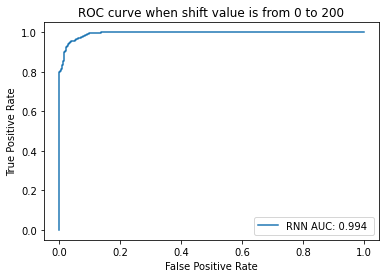

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.20it/s]

100%|██████████| 75/75 [00:00<00:00, 105.35it/s]

100%|██████████| 75/75 [00:00<00:00, 105.06it/s]

100%|██████████| 75/75 [00:00<00:00, 105.21it/s]

100%|██████████| 75/75 [00:00<00:00, 105.65it/s]

100%|██████████| 75/75 [00:00<00:00, 105.46it/s]

100%|██████████| 75/75 [00:00<00:00, 105.50it/s]

100%|██████████| 75/75 [00:00<00:00, 105.38it/s]

100%|██████████| 75/75 [00:00<00:00, 101.50it/s][A

100%|██████████| 75/75 [00:00<00:00, 105.46it/s]

100%|██████████| 75/75 [00:00<00:00, 105.39it/s]

100%|██████████| 75/75 [00:00<00:00, 106.34it/s]

100%|██████████| 75/75 [00:00<00:00, 106.53it/s]

100%|██████████| 75/75 [00:00<00:00, 106.12it/s]

100%|██████████| 75/75 [00:00<00:00, 106.51it/s]

100%|██████████| 75/75 [00:00<00:00, 106.53it/s]

100%|██████████| 75/75 [00:00<00:00, 106.63it/s]

100%|██████████| 75/75 [00:00<00:00, 101.64it/s]

100%|██████████| 75/75 [00:00<00:00, 106.52it/s]

100%|██████████| 75/75 [00:00<00:00, 106.52it/s

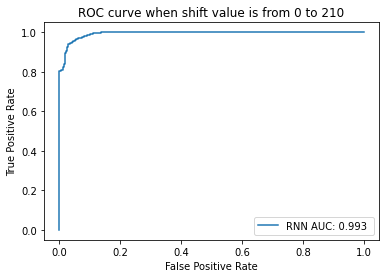

#params 837635



100%|██████████| 75/75 [00:00<00:00, 106.13it/s]

100%|██████████| 75/75 [00:00<00:00, 106.30it/s]

100%|██████████| 75/75 [00:00<00:00, 106.62it/s]

100%|██████████| 75/75 [00:00<00:00, 106.54it/s]

100%|██████████| 75/75 [00:00<00:00, 106.34it/s]

100%|██████████| 75/75 [00:00<00:00, 106.45it/s]

100%|██████████| 75/75 [00:00<00:00, 106.55it/s]

100%|██████████| 75/75 [00:00<00:00, 106.24it/s]

100%|██████████| 75/75 [00:00<00:00, 106.48it/s]

100%|██████████| 75/75 [00:00<00:00, 106.47it/s]

100%|██████████| 75/75 [00:00<00:00, 105.93it/s]

100%|██████████| 75/75 [00:00<00:00, 102.40it/s]

100%|██████████| 75/75 [00:00<00:00, 106.28it/s]

100%|██████████| 75/75 [00:00<00:00, 106.30it/s]

100%|██████████| 75/75 [00:00<00:00, 105.51it/s]

100%|██████████| 75/75 [00:00<00:00, 105.97it/s]

100%|██████████| 75/75 [00:00<00:00, 106.24it/s]

100%|██████████| 75/75 [00:00<00:00, 106.37it/s]

100%|██████████| 75/75 [00:00<00:00, 106.28it/s]

100%|██████████| 75/75 [00:00<00:00, 106.42it/s]


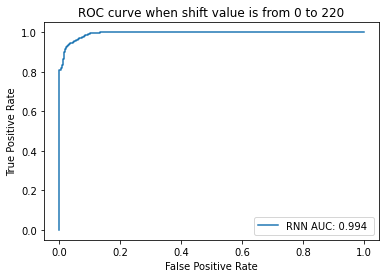

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.28it/s]

100%|██████████| 75/75 [00:00<00:00, 105.33it/s]

100%|██████████| 75/75 [00:00<00:00, 105.39it/s]

100%|██████████| 75/75 [00:00<00:00, 104.82it/s]

100%|██████████| 75/75 [00:00<00:00, 105.37it/s]

100%|██████████| 75/75 [00:00<00:00, 105.29it/s]

100%|██████████| 75/75 [00:00<00:00, 105.51it/s]

100%|██████████| 75/75 [00:00<00:00, 105.30it/s]

100%|██████████| 75/75 [00:00<00:00, 100.68it/s][A

100%|██████████| 75/75 [00:00<00:00, 105.33it/s]

100%|██████████| 75/75 [00:00<00:00, 105.36it/s]

100%|██████████| 75/75 [00:00<00:00, 105.42it/s]

100%|██████████| 75/75 [00:00<00:00, 105.05it/s]

100%|██████████| 75/75 [00:00<00:00, 105.44it/s]

100%|██████████| 75/75 [00:00<00:00, 105.36it/s]

100%|██████████| 75/75 [00:00<00:00, 104.93it/s]

100%|██████████| 75/75 [00:00<00:00, 105.38it/s]

100%|██████████| 75/75 [00:00<00:00, 105.29it/s]

100%|██████████| 75/75 [00:00<00:00, 105.39it/s]

100%|██████████| 75/75 [00:00<00:00, 105.27it/s

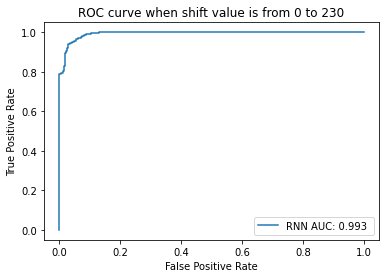

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.29it/s]

100%|██████████| 75/75 [00:00<00:00, 104.82it/s]

100%|██████████| 75/75 [00:00<00:00, 105.47it/s]

100%|██████████| 75/75 [00:00<00:00, 105.51it/s]

100%|██████████| 75/75 [00:00<00:00, 105.36it/s]

100%|██████████| 75/75 [00:00<00:00, 105.62it/s]

100%|██████████| 75/75 [00:00<00:00, 105.37it/s]

100%|██████████| 75/75 [00:00<00:00, 105.42it/s]

100%|██████████| 75/75 [00:00<00:00, 105.51it/s]

100%|██████████| 75/75 [00:00<00:00, 105.36it/s]

100%|██████████| 75/75 [00:00<00:00, 105.36it/s]

100%|██████████| 75/75 [00:00<00:00, 104.99it/s]

100%|██████████| 75/75 [00:00<00:00, 105.46it/s]

100%|██████████| 75/75 [00:00<00:00, 105.40it/s]

100%|██████████| 75/75 [00:00<00:00, 105.35it/s]

100%|██████████| 75/75 [00:00<00:00, 105.14it/s]

100%|██████████| 75/75 [00:00<00:00, 105.40it/s]

100%|██████████| 75/75 [00:00<00:00, 105.31it/s]

100%|██████████| 75/75 [00:00<00:00, 105.19it/s]

100%|██████████| 75/75 [00:00<00:00, 105.23it/s]


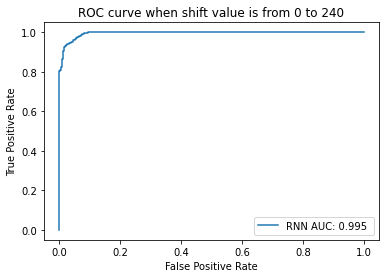

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.21it/s]

100%|██████████| 75/75 [00:00<00:00, 105.11it/s]

100%|██████████| 75/75 [00:00<00:00, 105.11it/s]

100%|██████████| 75/75 [00:00<00:00, 104.97it/s]

100%|██████████| 75/75 [00:00<00:00, 105.21it/s]

100%|██████████| 75/75 [00:00<00:00, 105.20it/s]

100%|██████████| 75/75 [00:00<00:00, 105.21it/s]

100%|██████████| 75/75 [00:00<00:00, 105.33it/s]

100%|██████████| 75/75 [00:00<00:00, 105.04it/s]

100%|██████████| 75/75 [00:00<00:00, 105.14it/s]

100%|██████████| 75/75 [00:00<00:00, 105.04it/s]

100%|██████████| 75/75 [00:00<00:00, 105.24it/s]

100%|██████████| 75/75 [00:00<00:00, 105.19it/s]

100%|██████████| 75/75 [00:00<00:00, 105.07it/s]

100%|██████████| 75/75 [00:00<00:00, 105.21it/s]

100%|██████████| 75/75 [00:00<00:00, 104.95it/s]

100%|██████████| 75/75 [00:00<00:00, 105.29it/s]

100%|██████████| 75/75 [00:00<00:00, 105.10it/s]

100%|██████████| 75/75 [00:00<00:00, 105.12it/s]

100%|██████████| 75/75 [00:00<00:00, 106.03it/s]


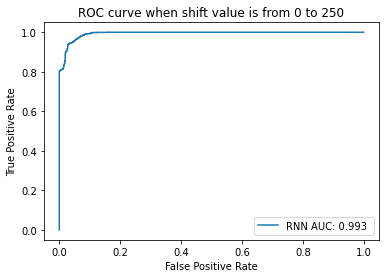

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.16it/s]

100%|██████████| 75/75 [00:00<00:00, 105.21it/s]

100%|██████████| 75/75 [00:00<00:00, 105.14it/s]

100%|██████████| 75/75 [00:00<00:00, 105.93it/s]

100%|██████████| 75/75 [00:00<00:00, 102.48it/s]

100%|██████████| 75/75 [00:00<00:00, 106.19it/s]

100%|██████████| 75/75 [00:00<00:00, 106.24it/s]

100%|██████████| 75/75 [00:00<00:00, 106.26it/s]

100%|██████████| 75/75 [00:00<00:00, 106.34it/s]

100%|██████████| 75/75 [00:00<00:00, 106.31it/s]

100%|██████████| 75/75 [00:00<00:00, 106.24it/s]

100%|██████████| 75/75 [00:00<00:00, 106.08it/s]

100%|██████████| 75/75 [00:00<00:00, 105.27it/s]

100%|██████████| 75/75 [00:00<00:00, 106.36it/s]

100%|██████████| 75/75 [00:00<00:00, 106.29it/s]

100%|██████████| 75/75 [00:00<00:00, 106.18it/s]

100%|██████████| 75/75 [00:00<00:00, 106.15it/s]

100%|██████████| 75/75 [00:00<00:00, 106.26it/s]

100%|██████████| 75/75 [00:00<00:00, 106.37it/s]

100%|██████████| 75/75 [00:00<00:00, 106.35it/s]


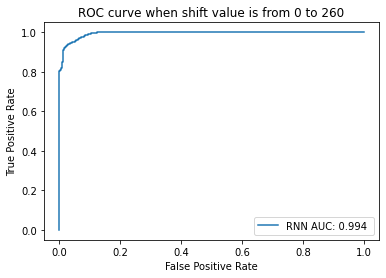

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.71it/s]

100%|██████████| 75/75 [00:00<00:00, 105.92it/s]

100%|██████████| 75/75 [00:00<00:00, 106.35it/s]

100%|██████████| 75/75 [00:00<00:00, 106.11it/s]

100%|██████████| 75/75 [00:00<00:00, 106.26it/s]

100%|██████████| 75/75 [00:00<00:00, 106.19it/s]

100%|██████████| 75/75 [00:00<00:00, 106.32it/s]

100%|██████████| 75/75 [00:00<00:00, 106.10it/s]

100%|██████████| 75/75 [00:00<00:00, 106.20it/s]

100%|██████████| 75/75 [00:00<00:00, 106.23it/s]

100%|██████████| 75/75 [00:00<00:00, 106.31it/s]

100%|██████████| 75/75 [00:00<00:00, 106.31it/s]

100%|██████████| 75/75 [00:00<00:00, 105.99it/s]

100%|██████████| 75/75 [00:00<00:00, 106.06it/s]

100%|██████████| 75/75 [00:00<00:00, 106.28it/s]

100%|██████████| 75/75 [00:00<00:00, 106.24it/s]

100%|██████████| 75/75 [00:00<00:00, 90.33it/s]

100%|██████████| 75/75 [00:00<00:00, 105.83it/s]

100%|██████████| 75/75 [00:00<00:00, 106.16it/s]

100%|██████████| 75/75 [00:00<00:00, 106.26it/s]



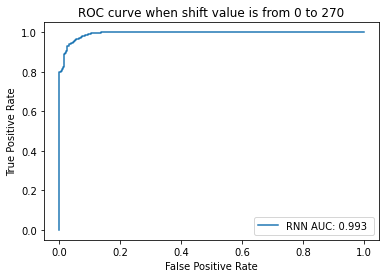

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.11it/s]

100%|██████████| 75/75 [00:00<00:00, 105.12it/s]

100%|██████████| 75/75 [00:00<00:00, 105.18it/s]

100%|██████████| 75/75 [00:00<00:00, 105.30it/s]

100%|██████████| 75/75 [00:00<00:00, 105.27it/s]

100%|██████████| 75/75 [00:00<00:00, 104.93it/s]

100%|██████████| 75/75 [00:00<00:00, 105.24it/s]

100%|██████████| 75/75 [00:00<00:00, 105.23it/s]

100%|██████████| 75/75 [00:00<00:00, 105.05it/s]

100%|██████████| 75/75 [00:00<00:00, 105.17it/s]

100%|██████████| 75/75 [00:00<00:00, 105.20it/s]

100%|██████████| 75/75 [00:00<00:00, 105.18it/s]

100%|██████████| 75/75 [00:00<00:00, 105.23it/s]

100%|██████████| 75/75 [00:00<00:00, 105.28it/s]

100%|██████████| 75/75 [00:00<00:00, 105.29it/s]

100%|██████████| 75/75 [00:00<00:00, 105.06it/s]

100%|██████████| 75/75 [00:00<00:00, 105.22it/s]

100%|██████████| 75/75 [00:00<00:00, 104.86it/s]

100%|██████████| 75/75 [00:00<00:00, 105.12it/s]

100%|██████████| 75/75 [00:00<00:00, 105.00it/s]


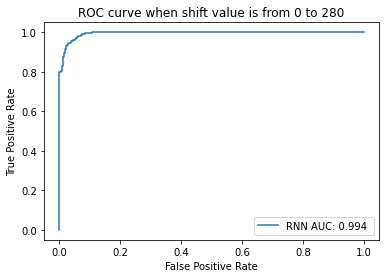

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.18it/s]

100%|██████████| 75/75 [00:00<00:00, 105.07it/s]

100%|██████████| 75/75 [00:00<00:00, 105.20it/s]

100%|██████████| 75/75 [00:00<00:00, 105.22it/s]

100%|██████████| 75/75 [00:00<00:00, 105.42it/s]

100%|██████████| 75/75 [00:00<00:00, 105.23it/s]

100%|██████████| 75/75 [00:00<00:00, 105.55it/s]

100%|██████████| 75/75 [00:00<00:00, 105.35it/s]

100%|██████████| 75/75 [00:00<00:00, 105.20it/s]

100%|██████████| 75/75 [00:00<00:00, 105.11it/s]

100%|██████████| 75/75 [00:00<00:00, 105.05it/s]

100%|██████████| 75/75 [00:00<00:00, 104.86it/s]

100%|██████████| 75/75 [00:00<00:00, 104.92it/s]

100%|██████████| 75/75 [00:00<00:00, 105.02it/s]

100%|██████████| 75/75 [00:00<00:00, 105.07it/s]

100%|██████████| 75/75 [00:00<00:00, 104.71it/s]

100%|██████████| 75/75 [00:00<00:00, 88.38it/s]

100%|██████████| 75/75 [00:00<00:00, 105.08it/s]

100%|██████████| 75/75 [00:00<00:00, 105.07it/s]

100%|██████████| 75/75 [00:00<00:00, 104.94it/s]



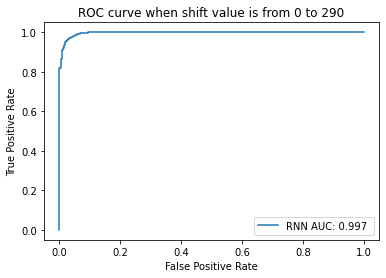

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.65it/s]

100%|██████████| 75/75 [00:00<00:00, 106.19it/s]

100%|██████████| 75/75 [00:00<00:00, 104.85it/s]

100%|██████████| 75/75 [00:00<00:00, 105.23it/s]

100%|██████████| 75/75 [00:00<00:00, 105.24it/s]

100%|██████████| 75/75 [00:00<00:00, 104.78it/s]

100%|██████████| 75/75 [00:00<00:00, 104.49it/s]

100%|██████████| 75/75 [00:00<00:00, 104.87it/s]

100%|██████████| 75/75 [00:00<00:00, 105.02it/s]

100%|██████████| 75/75 [00:00<00:00, 105.11it/s]

100%|██████████| 75/75 [00:00<00:00, 105.02it/s]

100%|██████████| 75/75 [00:00<00:00, 105.02it/s]

100%|██████████| 75/75 [00:00<00:00, 105.02it/s]

100%|██████████| 75/75 [00:00<00:00, 101.23it/s]

100%|██████████| 75/75 [00:00<00:00, 105.22it/s]

100%|██████████| 75/75 [00:00<00:00, 105.03it/s]

100%|██████████| 75/75 [00:00<00:00, 104.17it/s]

100%|██████████| 75/75 [00:00<00:00, 105.07it/s]

100%|██████████| 75/75 [00:00<00:00, 105.21it/s]

100%|██████████| 75/75 [00:00<00:00, 105.16it/s]


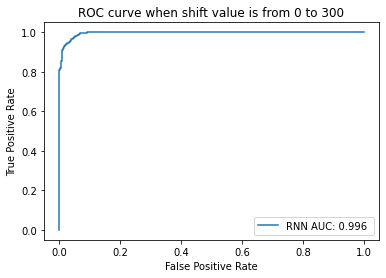

#params 837635



100%|██████████| 75/75 [00:00<00:00, 104.54it/s]

100%|██████████| 75/75 [00:00<00:00, 105.06it/s]

100%|██████████| 75/75 [00:00<00:00, 104.85it/s]

100%|██████████| 75/75 [00:00<00:00, 105.11it/s]

100%|██████████| 75/75 [00:00<00:00, 105.05it/s]

100%|██████████| 75/75 [00:00<00:00, 105.12it/s]

100%|██████████| 75/75 [00:00<00:00, 105.07it/s]

100%|██████████| 75/75 [00:00<00:00, 101.43it/s]

100%|██████████| 75/75 [00:00<00:00, 104.94it/s]

100%|██████████| 75/75 [00:00<00:00, 105.14it/s]

100%|██████████| 75/75 [00:00<00:00, 104.77it/s]

100%|██████████| 75/75 [00:00<00:00, 104.56it/s]

100%|██████████| 75/75 [00:00<00:00, 104.99it/s]

100%|██████████| 75/75 [00:00<00:00, 105.06it/s]

100%|██████████| 75/75 [00:00<00:00, 104.70it/s]

100%|██████████| 75/75 [00:00<00:00, 104.64it/s]

100%|██████████| 75/75 [00:00<00:00, 105.05it/s]

100%|██████████| 75/75 [00:00<00:00, 104.90it/s]

100%|██████████| 75/75 [00:00<00:00, 100.96it/s]

100%|██████████| 75/75 [00:00<00:00, 105.16it/s]


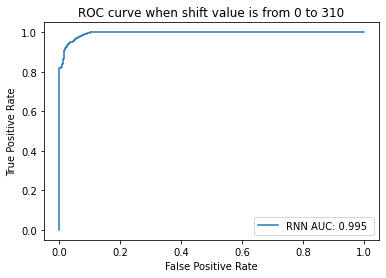

#params 837635



100%|██████████| 75/75 [00:00<00:00, 105.06it/s]

100%|██████████| 75/75 [00:00<00:00, 104.89it/s]

100%|██████████| 75/75 [00:00<00:00, 104.86it/s]

100%|██████████| 75/75 [00:00<00:00, 104.96it/s]

100%|██████████| 75/75 [00:00<00:00, 105.09it/s]

100%|██████████| 75/75 [00:00<00:00, 104.95it/s]

100%|██████████| 75/75 [00:00<00:00, 105.16it/s]

100%|██████████| 75/75 [00:00<00:00, 104.93it/s]

100%|██████████| 75/75 [00:00<00:00, 104.91it/s]

100%|██████████| 75/75 [00:00<00:00, 105.13it/s]

100%|██████████| 75/75 [00:00<00:00, 105.18it/s]

100%|██████████| 75/75 [00:00<00:00, 105.06it/s]

100%|██████████| 75/75 [00:00<00:00, 105.06it/s]

100%|██████████| 75/75 [00:00<00:00, 105.10it/s]

100%|██████████| 75/75 [00:00<00:00, 105.08it/s]

100%|██████████| 75/75 [00:00<00:00, 105.33it/s]

100%|██████████| 75/75 [00:00<00:00, 104.66it/s]

100%|██████████| 75/75 [00:00<00:00, 105.06it/s]

100%|██████████| 75/75 [00:00<00:00, 104.91it/s]

100%|██████████| 75/75 [00:00<00:00, 105.03it/s]


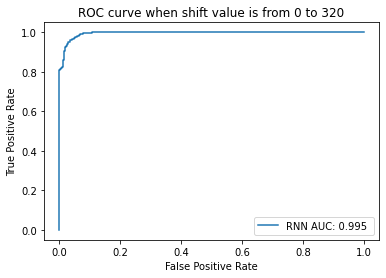

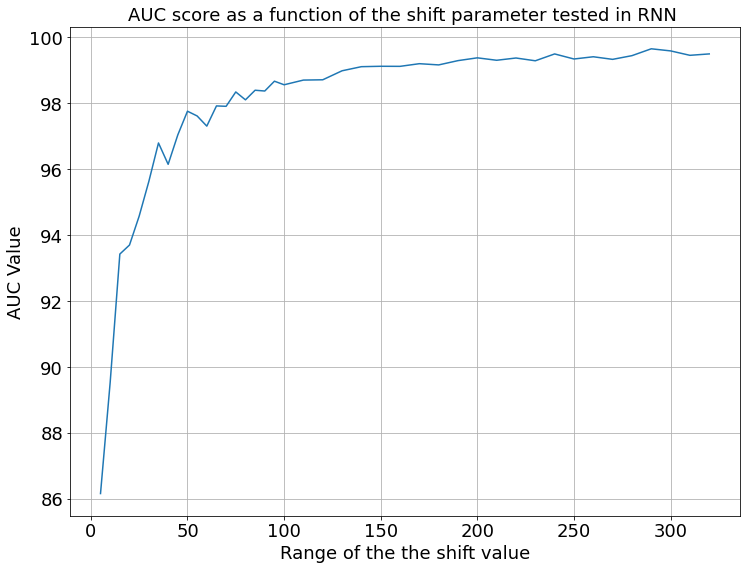

In [12]:
import tqdm
from tqdm.notebook import tnrange

NUM_EPOCHS = 50
LEARNING_RATE =0.01

def plot_accVsshift(x, y, ylbl='AUC Value'):
    fntSize = 18
    plt.figure(figsize=(12, 9))
    plt.plot(np.array(x), np.array(y)*100)
    plt.grid()
    plt.title("AUC score as a function of the shift parameter tested in RNN ", fontsize = fntSize)
    plt.xlabel("Range of the the shift value", fontsize = fntSize)
    plt.ylabel(ylbl, fontsize = fntSize)
    plt.xticks(fontsize = fntSize)
    plt.yticks(fontsize = fntSize)
    plt.savefig("AUCvShift_RNN.png",dpi=200)
    plt.show()
    plt.close()
    
def get_roc(bkgdataFile,sigdataFile):
    bkgdata = np.load(bkgdataFile)
    bkg = bkgdata['output'].tolist()
    sigdata = np.load(sigdataFile)
    sig = sigdata['output'].tolist()
    testY = np.array([1]*len(sig) + [0]*len(bkg))
    predY = np.array(sig+bkg)
    auc = roc_auc_score(testY, predY)
    fpr, tpr, thr = roc_curve(testY, predY)
    return fpr,tpr,thr,auc

def rocCurvePlotRNN(sft,fpr_rnn,tpr_rnn,auc_rnn):
    plt.plot(fpr_rnn,tpr_rnn,label="RNN AUC: %.3f "%(auc_rnn))
    plt.title("ROC curve when shift value is from 0 to "+str(sft))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.savefig("ROC_"+str(sft)+"shift.png",dpi=200)
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()    

shiftParams = []
auc_score = []
fpr_value =[]
tpr_value = []
thr_value = []
# sfts = list(range(5, 100, 5)) + list(range(100, 690, 10))
sfts = list(range(5, 100, 5)) +list(range(100,330,10))
for i in tnrange(len(sfts), desc="Shift"):
    sft = sfts[i]
    wf_extract(sft, 0)
    wf_extract(sft, 1)
    run_wf_in_nn(sft)
      # Plot the ROC curve for RNN 
    fpr_rnn, tpr_rnn, thr_rnn, auc_rnn = get_roc("rnn_bkgoutput.npz", "rnn_sigoutput.npz")
    rocCurvePlotRNN(sft,fpr_rnn,tpr_rnn,auc_rnn)
    auc_score.append(auc_rnn)
    shiftParams.append(sft)
    fpr_value.append(fpr_rnn)
    tpr_value.append(tpr_rnn)
    thr_value.append(thr_rnn)
plot_accVsshift(shiftParams,auc_score)

In [14]:
with open("shift_aucScore_rnn.txt", "w") as f:
    f.writelines(map("{},{}\n".format, shiftParams, auc_score))